# 🔬 SHAP Analysis for Karachi AQI Prediction Model

**Goal**: Understand how our GradientBoosting model makes AQI predictions

## What is SHAP?
SHAP (SHapley Additive exPlanations) helps us answer:
- Which features matter most for predictions?
- How does each feature affect the AQI prediction?
- Why did the model predict a specific AQI value?

**Model**: GradientBoosting Regressor  
**Best Performance**: MAE: 0.28, RMSE: 2.07, R²: 0.9976

## 1️ Setup and Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import json
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2️ Load Trained Model

In [30]:
# Load model
project_root = Path.cwd().parent.parent
model = joblib.load(project_root / "artifacts" / "model.joblib")
print(f"✅ Model: {type(model).__name__}")

# Connect to Hopsworks
project = hopsworks.login(api_key_value=os.getenv("HOPSWORKS_API_KEY"))
fs = project.get_feature_store()
fv = fs.get_feature_view(name="karachi_air_quality_fv", version=3)

# Get data
train_df, val_df, test_df, _, _, _ = fv.train_validation_test_split(
    validation_size=0.15, test_size=0.15
)

print(f"✅ Data loaded: {len(test_df)} test samples")

✅ Model: GradientBoostingRegressor
2026-01-31 16:50:58,641 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-31 16:50:58,652 INFO: Initializing external client
2026-01-31 16:50:58,654 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-31 16:51:02,552 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1338526
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.35s) 
✅ Data loaded: 1331 test samples


In [31]:
# Prepare features
features = ['pm2_5', 'pm10', 'carbon_monoxide', 'nitrogen_dioxide',
            'sulphur_dioxide', 'ozone', 'hour', 'day', 'month', 'weekday',
            'pm2_5_lag1', 'pm2_5_lag2', 'pm2_5_roll3']

X_sample = test_df[features].sample(500, random_state=42)
y_sample = test_df.loc[X_sample.index, 'aqi']

# Calculate SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(f"✅ SHAP calculated for {len(X_sample)} samples")

✅ SHAP calculated for 500 samples


## 📊 Feature Importance

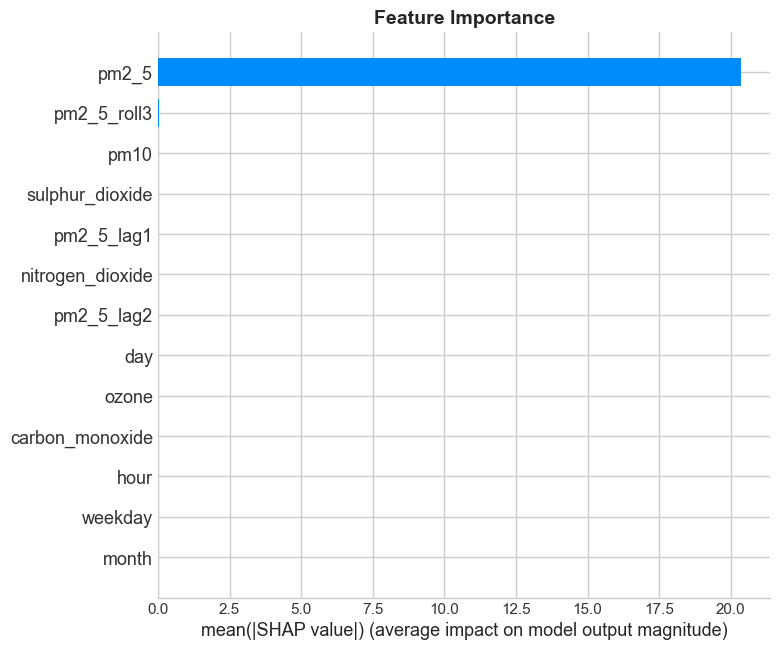

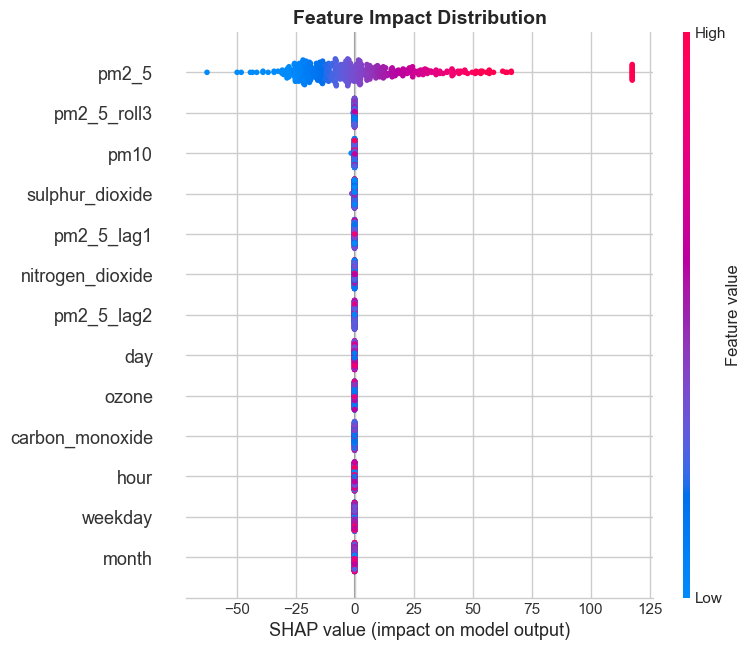


🏆 Top 5 Features:
 Rank         Feature  Importance
    1           pm2_5   20.367013
    2     pm2_5_roll3    0.026274
    3            pm10    0.010849
    4 sulphur_dioxide    0.004674
    5      pm2_5_lag1    0.002137


In [32]:
# Bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Feature Importance", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_importance.png', dpi=300)
plt.show()

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("Feature Impact Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300)
plt.show()

# Importance table
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(shap_values).mean(0)
}).sort_values('Importance', ascending=False).reset_index(drop=True)
importance_df['Rank'] = range(1, len(importance_df) + 1)

print("\n🏆 Top 5 Features:")
print(importance_df[['Rank', 'Feature', 'Importance']].head().to_string(index=False))

## 🔍 Feature Dependence - Top 3 Features

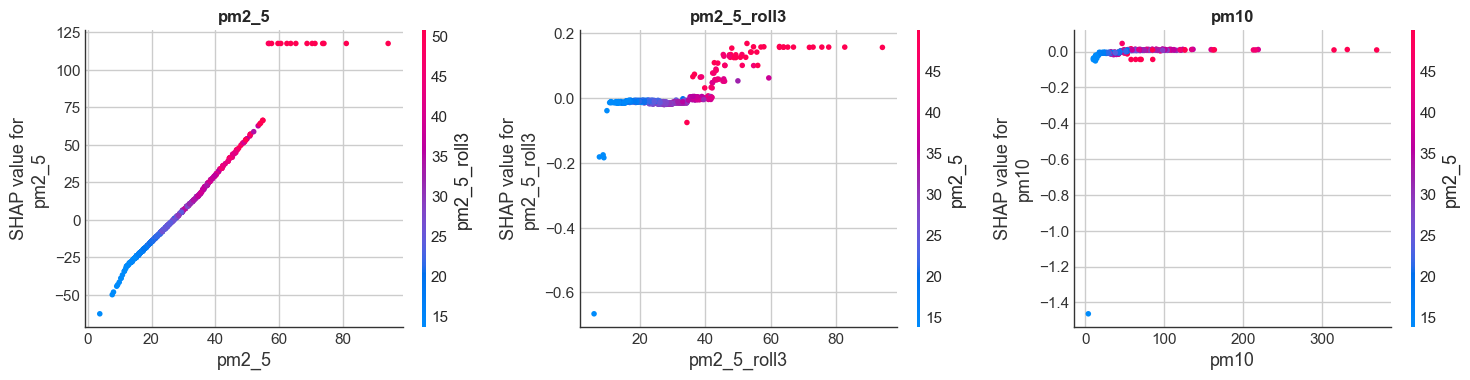

In [33]:
top_3 = importance_df.head(3)['Feature'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, feature in enumerate(top_3):
    shap.dependence_plot(feature, shap_values, X_sample, 
                         interaction_index='auto', ax=axes[idx], show=False)
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('shap_dependence.png', dpi=300)
plt.show()

## 🌊 Individual Predictions - Waterfall Plots


High AQI: Predicted=200.0, Actual=200.0


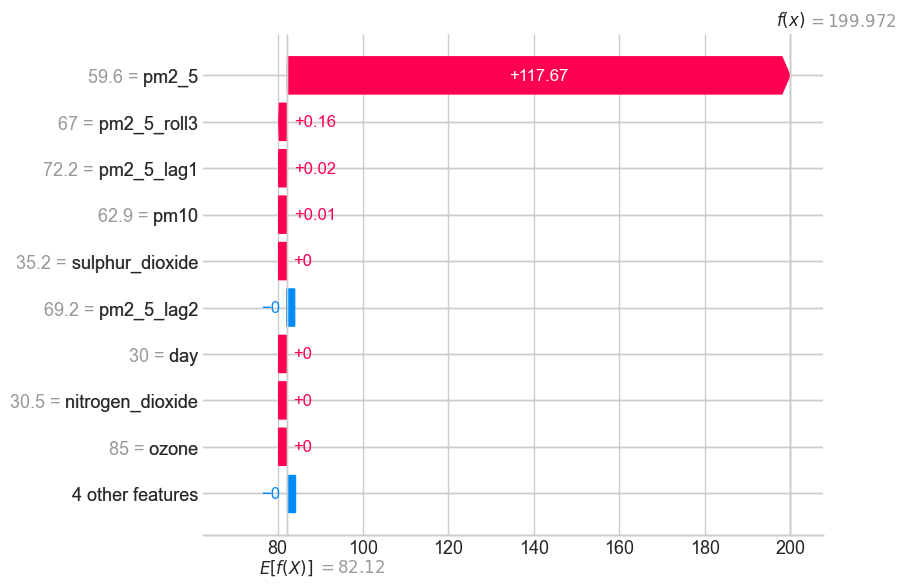


Low AQI: Predicted=16.2, Actual=15.8


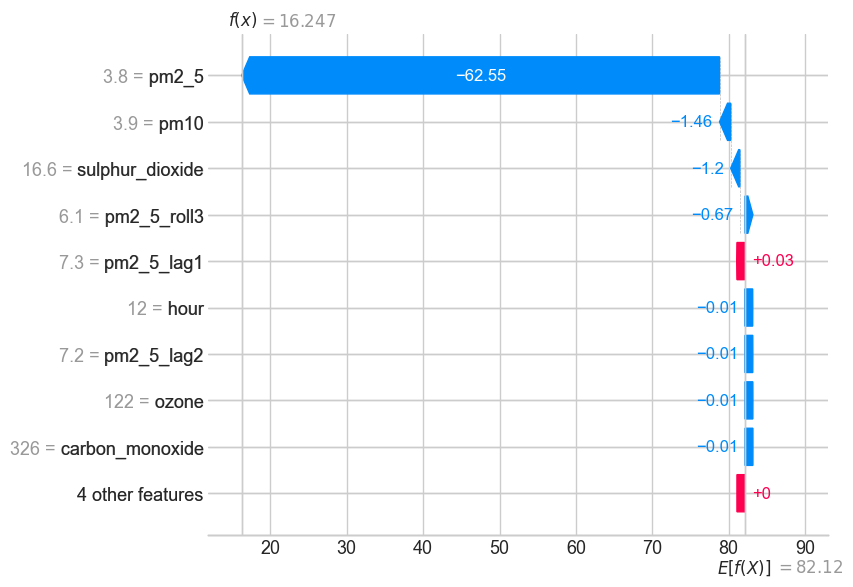


Median AQI: Predicted=78.5, Actual=78.3


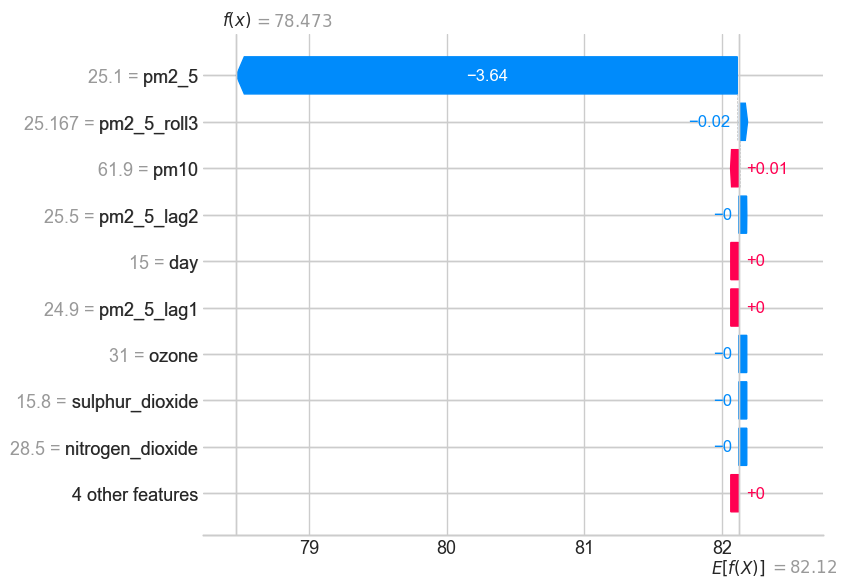


✅ SHAP Analysis Complete!
📊 Top feature: pm2_5
💾 Saved 5 PNG files


<Figure size 1200x600 with 0 Axes>

In [34]:
predictions = model.predict(X_sample)

# High, Low, Median cases
cases = {
    'High AQI': predictions.argmax(),
    'Low AQI': predictions.argmin(),
    'Median AQI': np.abs(predictions - np.median(predictions)).argmin()
}

expected_val = explainer.expected_value
if isinstance(expected_val, np.ndarray):
    expected_val = expected_val[0]

for name, idx in cases.items():
    print(f"\n{name}: Predicted={predictions[idx]:.1f}, Actual={y_sample.iloc[idx]:.1f}")
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[idx],
            base_values=expected_val,
            data=X_sample.iloc[idx],
            feature_names=features
        ),
        max_display=10
    )
    plt.savefig(f'waterfall_{name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')

print("\n✅ SHAP Analysis Complete!")
print(f"📊 Top feature: {importance_df.iloc[0]['Feature']}")
print(f"💾 Saved 5 PNG files")

## 📈 Summary Statistics

In [35]:
print("=" * 70)
print("📊 SHAP ANALYSIS SUMMARY - KARACHI AQI PREDICTOR")
print("=" * 70)

print(f"\n🔬 Model Information:")
print(f"   Model: {type(model).__name__}")
print(f"   Best Model: GradientBoosting")
print(f"   MAE:  0.2776")
print(f"   RMSE: 2.0713")
print(f"   R²:   0.9976")

print(f"\n📊 Analysis Details:")
print(f"   Samples analyzed: {len(X_sample)}")
print(f"   Features: {len(features)}")
print(f"   Base prediction: {expected_val:.2f}")
print(f"   SHAP range: [{shap_values.min():.2f}, {shap_values.max():.2f}]")
print(f"   Mean |SHAP|: {np.abs(shap_values).mean():.2f}")

print(f"\n🏆 Top 5 Important Features:")
for _, row in importance_df.head(5).iterrows():
    print(f"   {row['Rank']}. {row['Feature']:20s} {row['Importance']:.4f}")

print(f"\n🎯 Sample Predictions:")
for name, idx in cases.items():
    pred = predictions[idx]
    actual = y_sample.iloc[idx]
    error = abs(pred - actual)
    print(f"   {name:12s}: Pred={pred:6.2f} | Actual={actual:6.2f} | Error={error:5.2f}")

print(f"\n💾 Saved Files:")
print(f"   - feature_importance.csv")
print(f"   - shap_importance.png")
print(f"   - shap_summary.png")
print(f"   - shap_dependence.png")
print(f"   - waterfall_high_aqi.png")
print(f"   - waterfall_low_aqi.png")
print(f"   - waterfall_median_aqi.png")

print("\n✅ SHAP Analysis Complete!")
print("=" * 70)

📊 SHAP ANALYSIS SUMMARY - KARACHI AQI PREDICTOR

🔬 Model Information:
   Model: GradientBoostingRegressor
   Best Model: GradientBoosting
   MAE:  0.2776
   RMSE: 2.0713
   R²:   0.9976

📊 Analysis Details:
   Samples analyzed: 500
   Features: 13
   Base prediction: 82.12
   SHAP range: [-62.55, 117.67]
   Mean |SHAP|: 1.57

🏆 Top 5 Important Features:
   1. pm2_5                20.3670
   2. pm2_5_roll3          0.0263
   3. pm10                 0.0108
   4. sulphur_dioxide      0.0047
   5. pm2_5_lag1           0.0021

🎯 Sample Predictions:
   High AQI    : Pred=199.97 | Actual=200.00 | Error= 0.03
   Low AQI     : Pred= 16.25 | Actual= 15.83 | Error= 0.41
   Median AQI  : Pred= 78.47 | Actual= 78.34 | Error= 0.13

💾 Saved Files:
   - feature_importance.csv
   - shap_importance.png
   - shap_summary.png
   - shap_dependence.png
   - waterfall_high_aqi.png
   - waterfall_low_aqi.png
   - waterfall_median_aqi.png

✅ SHAP Analysis Complete!
